In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from skimage import io
from skimage.morphology import erosion, dilation, disk, closing, opening
from skimage.segmentation import watershed
from scipy.ndimage import convolve
import skimage.measure as skmeasure

In [99]:
def showim(arr_copy, figsize=(4, 4), show_hist=False, nbins=None, bin_width=None, cmap='gray', vmin=None, vmax=None, titles=None):
    
    if isinstance(arr_copy, (list, tuple)):
        n_images = len(arr_copy)
        fig_width, fig_height = figsize
        plt.figure(figsize=(fig_width * n_images, fig_height))
        
        for idx, img in enumerate(arr_copy):
            plt.subplot(1, n_images, idx + 1)
            plt.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, (list, tuple)) and len(titles) == n_images:
                plt.title(titles[idx])
            elif titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
        plt.tight_layout()
        
        plt.show()
    else:
        plt.figure(figsize=figsize)
        
        if show_hist:
            plt.subplot(1, 2, 1)
            plt.imshow(arr_copy, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
            plt.subplot(1, 2, 2)
            
            im_flattened = arr_copy.ravel()
            min_val = np.floor(im_flattened.min())
            max_val = np.ceil(im_flattened.max())
            
            if bin_width is not None:
                bins = np.arange(min_val, max_val + bin_width, bin_width)
            elif nbins is not None:
                bins = nbins
            else:
                bins = int(max_val - min_val)
            
            plt.hist(im_flattened, bins=bins, color='black')
            plt.xlabel('Intensity Value')
            plt.ylabel('Frequency')
            plt.title('Image Intensity Histogram')
        
        else:
            plt.imshow(arr_copy, cmap=cmap, vmin=vmin, vmax=vmax)
            
            if titles and isinstance(titles, str):
                plt.title(titles)
            
            plt.axis('off')
        plt.tight_layout()
        plt.show()

def renorm_uint8(im):
    im = (255 * (im - np.min(im)) / (np.max(im) - np.min(im))).astype(np.uint8)
    return im

def binarize(im, threshold=0):
    im = np.where(im > threshold, 1, 0).astype(np.uint8)
    return im


## 1) Spot Removal (8 pts.)

**Download the file “Lichtenstein_imageDuplicator_1963.png” – a painting called “Image Duplicator” by Roy Lichtenstein (1963). Also download the gray version, which I made by averaging the color channels: “Lichtenstein_imageDuplicator_1963_gray.png”.** 

**Your task: Remove the dots on the man’s face! (Leaving the rest of the image as intact as possible. Note that perfection is impossible.)**

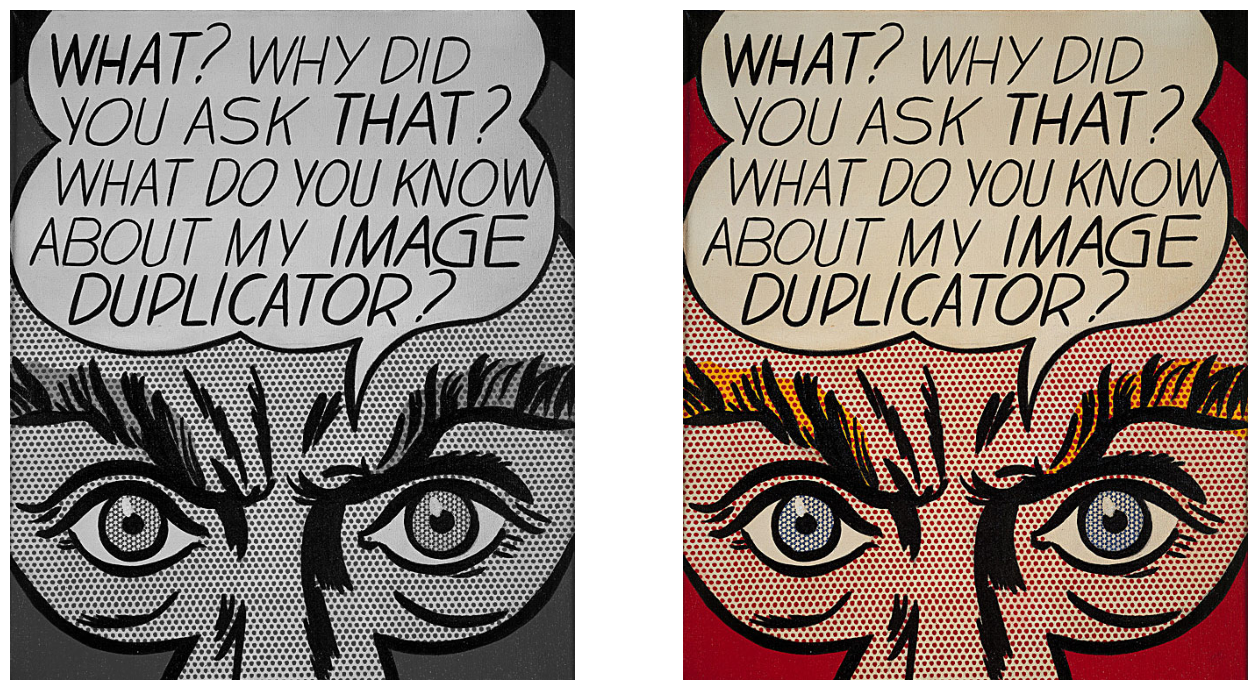

In [100]:
im_gray = io.imread('/home/apd/Projects/ImageAnalysis/HW8/Lichtenstein_imageDuplicator_1963_gray.png')
im_color = io.imread('/home/apd/Projects/ImageAnalysis/HW8/Lichtenstein_imageDuplicator_1963.png')
showim((im_gray, im_color), figsize=(7,7))

#### a)  (6  pts.) 

*First,  remove  the  dots  as  best  you  can  with  the grayscale version. For now, don’t worry if you also disturb the dots in the eyes or eyebrows, or if the lettering is messed up. Can you do this in one line of code? Write the relevant lines of code and also show your output image.*

In [101]:
closed_im = closing(im_gray, disk(5))
#showim(closed_im, figsize=(11,11))

In [102]:
A = closing(im_gray, disk(1))
B = dilation(A, disk(3))
C = erosion(B, disk(3))
D = opening(C, disk(2))
#showim((im_gray, A, B, C, D), figsize=(22,44))

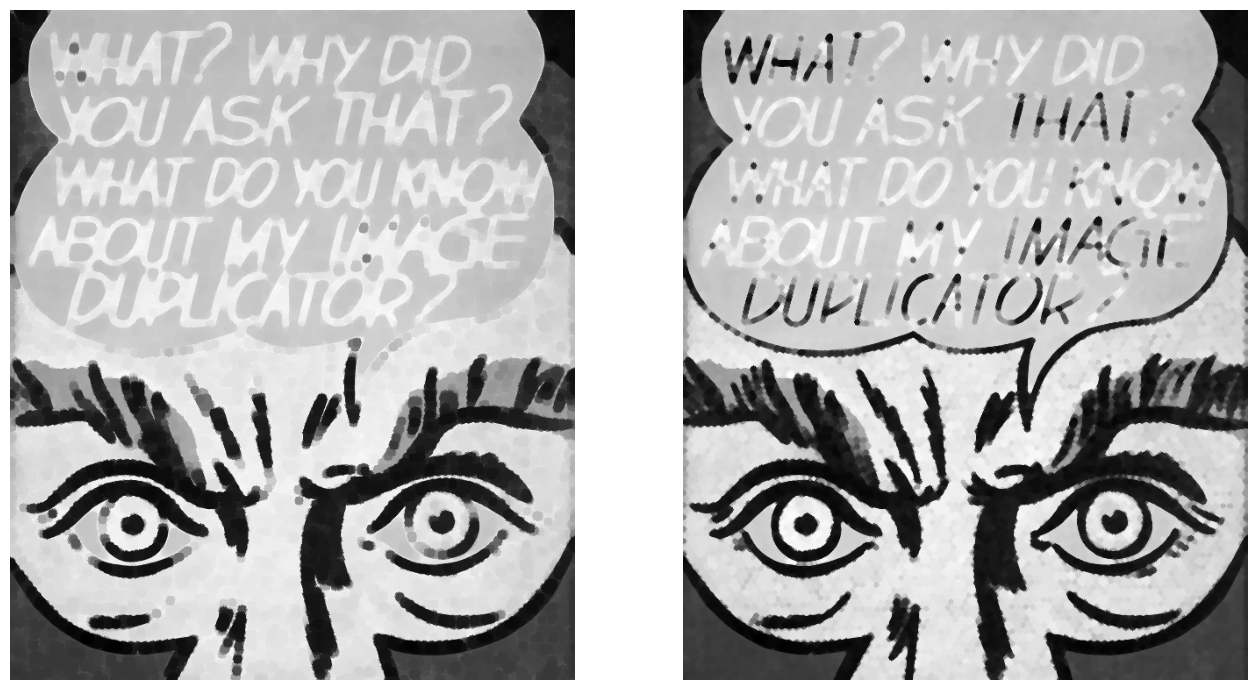

In [103]:
showim((closed_im,D), figsize=(7,7))

In the above, we see my attempt at a one-line solution (closing) on the left, and my attempt after several morphological operations on the right, where I try to preserve the other features a bit more.

#### b) (2 pts.)

*Now  consider  the  color  image.  See  if  you  can  figure  out  a  way  to remove  only  the  red  dots.  This  takes some  thinking  about  what’s  different  between  the different color channels. I’m only assigning this 2 points not because it’s easy (it isn’t!), but because it’s not important.*

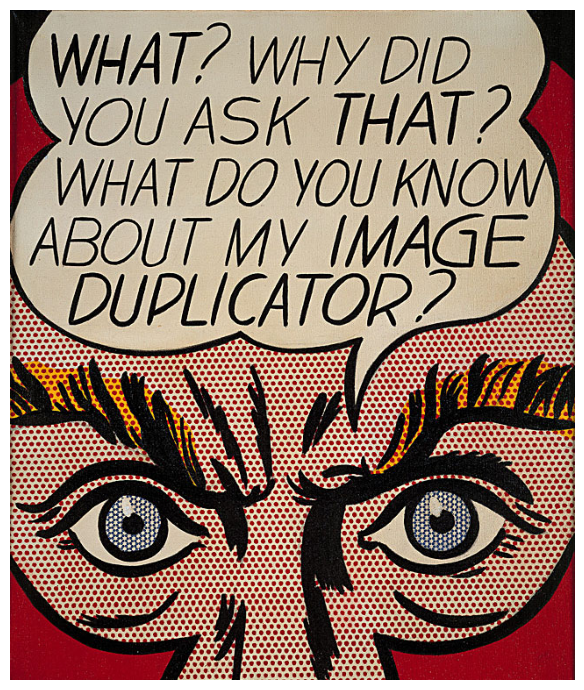

In [104]:
showim(im_color, figsize=(7,7))

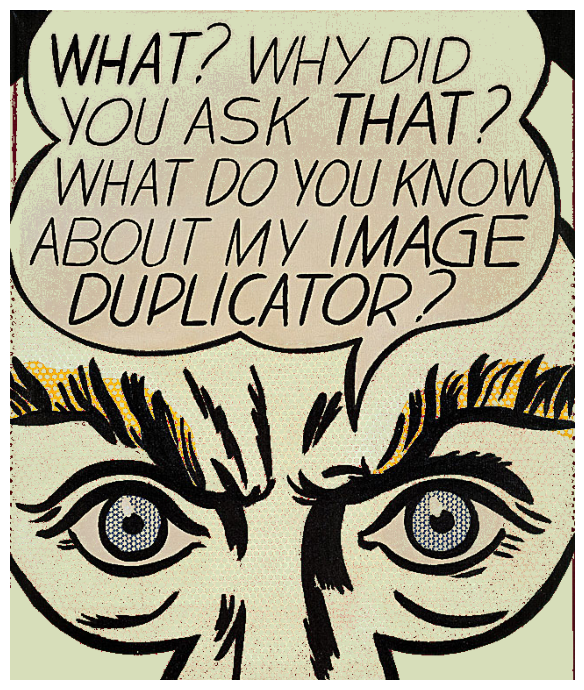

In [105]:
blank = im_color.copy()

red_layer = blank[:,:,0]
green_layer = blank[:,:,1]
blue_layer = blank[:,:,2]

#stats = skmeasure.regionprops(red_layer) 
#areas = [stats[j]['Area'] for j in range(len(stats))] 
#eccentricities = [stats[j]['Eccentricity'] for j in range(len(stats))]
#plt.scatter(eccentricities, areas);
#plt.xlabel('Eccentricity')
#plt.ylabel('Area')

lower_threshold = 100  
upper_threshold = 200  

blank = im_color.copy()
red_layer = blank[:, :, 0]

threshold_mask = (red_layer >= lower_threshold) & (red_layer <= upper_threshold)
thresholded_image = np.zeros_like(red_layer)
thresholded_image[threshold_mask] = red_layer[threshold_mask]

red_layer[threshold_mask] = 215
green_layer[threshold_mask] = 222
blue_layer[threshold_mask] = 186
blank[:,:,0] = red_layer
blank[:,:,1] = green_layer
blank[:,:,2] = blue_layer
showim(blank, figsize=(7,7))

I just applied a simple thresholding to just the red layer and anually replace it with a beige color. The obvious major downside of this is that it get's rid of the red on the border of the image, which could perhaps be tweaked with thresholding being conditional on the other color channels as well if there is indeed a difference in hue between the reds of the dots and the red of the borders. I'd do some feature/region area and eccentricity analysis but I'm tired and it said not to spend to much time on this!

## 2  Segmentation  by  thresholding  (4  pts.)

**Before  trying  out  watershed segmentation, let’s revisit thresholding. In the following problems, we’ll look at an  image  of  yeast  colonies  on  a  petri  dish, “dsc_0357_gray.png”**

**The  overall  goal will  be  to  write  a  function  that,  with  a  few  user-input  parameters,  returns  the  location  of  each colony, its size (pixels), and eccentricity (which may indicate errors in identification of colonies).**

#### a) (4 pts.) 

*Apply whatever filtering seems appropriate to the yeast colony image. Keep in mind both  high-  and  low-  pass filtering. (Recall what’s useful about each.  As  always,  be  careful about  intensity  ranges!) We’ll use this filtered image now, and in later problems. Threshold to make a binary image that highlights the colonies. (Colonies = 1, background = 0.) Submit the resulting image – we’ll call this array im_bw – and explain what filtering you did.* 

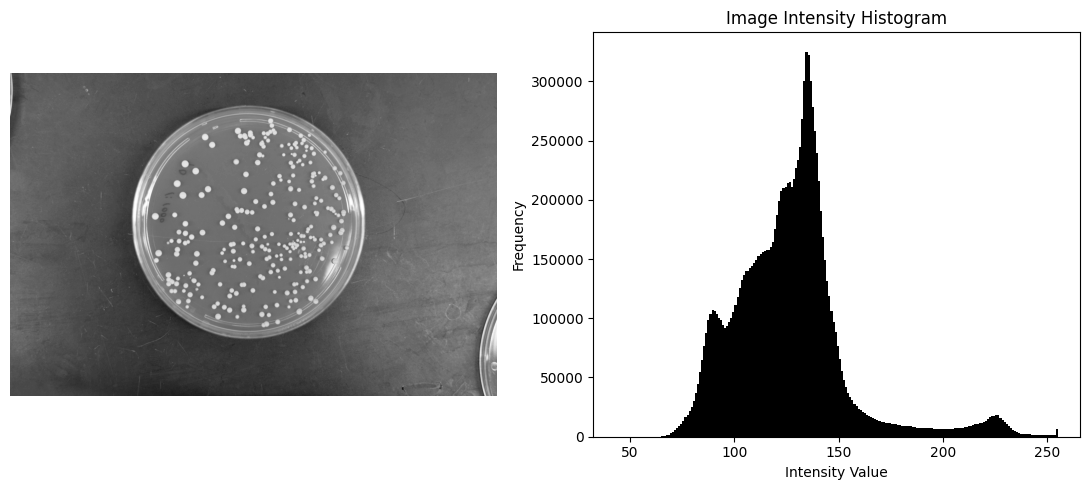

In [106]:
im = io.imread('/home/apd/Projects/ImageAnalysis/HW8/dsc_0357_gray.png')
showim(im, show_hist=True, figsize=(11,5))

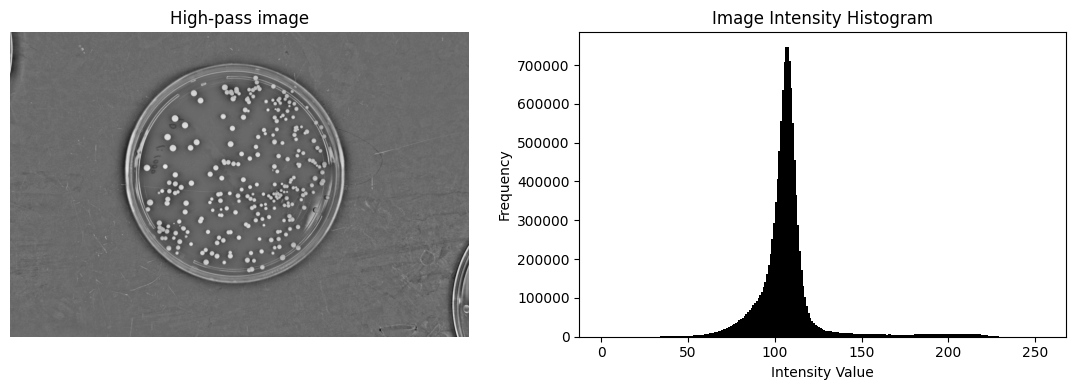

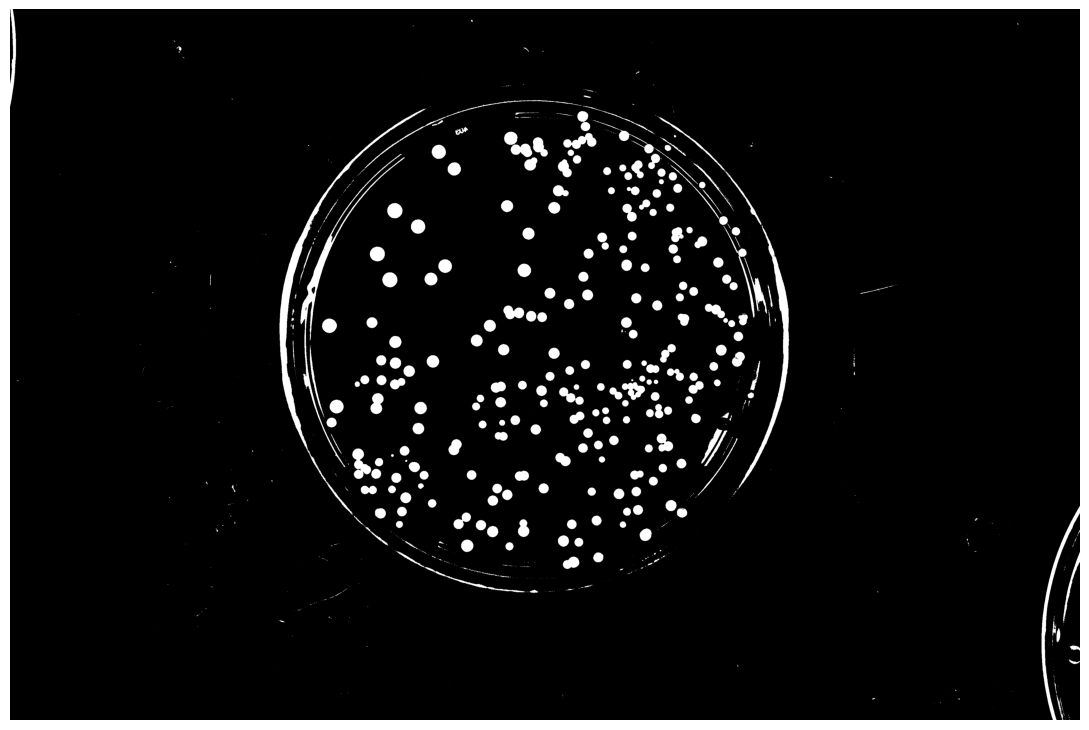

In [107]:
gauss_im = gaussian(im, sigma=50)*255 
im_highpass = renorm_uint8(im - gauss_im)
showim(im_highpass, figsize = (11, 4), show_hist=True, titles='High-pass image')

threshold = 160
im_threshed = im_highpass.copy()
im_threshed[im_threshed < threshold] = 0
im_bw = binarize(im_threshed)

showim(im_bw, figsize=(11,11))

I made a highpass image to find the edges/brightspots then did a threshold on that highpass image to try and filter out as much of the background and pitri dish as possible without losing  the features of the cells.

#### b)  (1 pt.) 

*Groups of connected “1” pixels are called regions. We can get various properties of all the regions in a binary image using  standard tools noted in class (Nov. 14). This is quite boring; I’ve written the code for you. Run the following:*

Text(0, 0.5, 'Area')

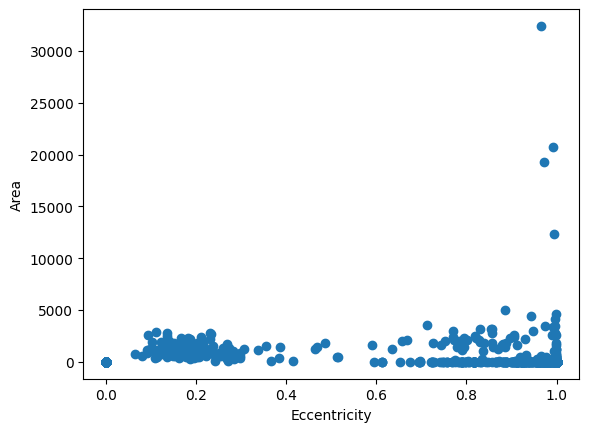

In [ ]:
label_img = skmeasure.label(im_bw)   
stats = skmeasure.regionprops(label_img)  

label_img = skmeasure.label(im_bw) 
stats = skmeasure.regionprops(label_img) 
 
areas = [stats[j]['Area'] for j in range(len(stats))] 
eccentricities = [stats[j]['Eccentricity'] for j in range(len(stats))]

plt.scatter(eccentricities, areas);
plt.xlabel('Eccentricity')
plt.ylabel('Area')

## 3 Gradient magnitude (3 pts.)

*Convolve the filtered (not thresholded) yeast colony image with 5x5 Sobel  filters  (shown  below)  to  get  the  gradients  in  x  and  y.  Then  calculate, display,  and  submit  the gradient magnitude (i.e. sqrt($G_{x}^2 + G_{y}^2$)) image.*

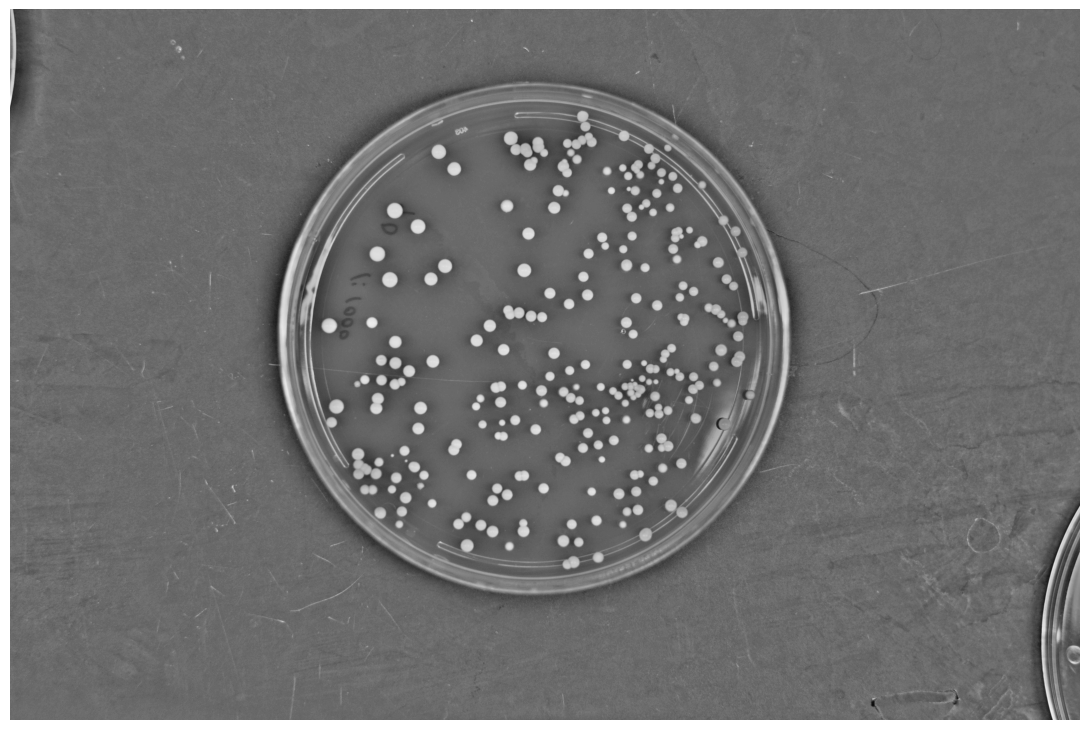

In [109]:
im_filtered = im_highpass / 255
showim(im_filtered, figsize=(11,11))

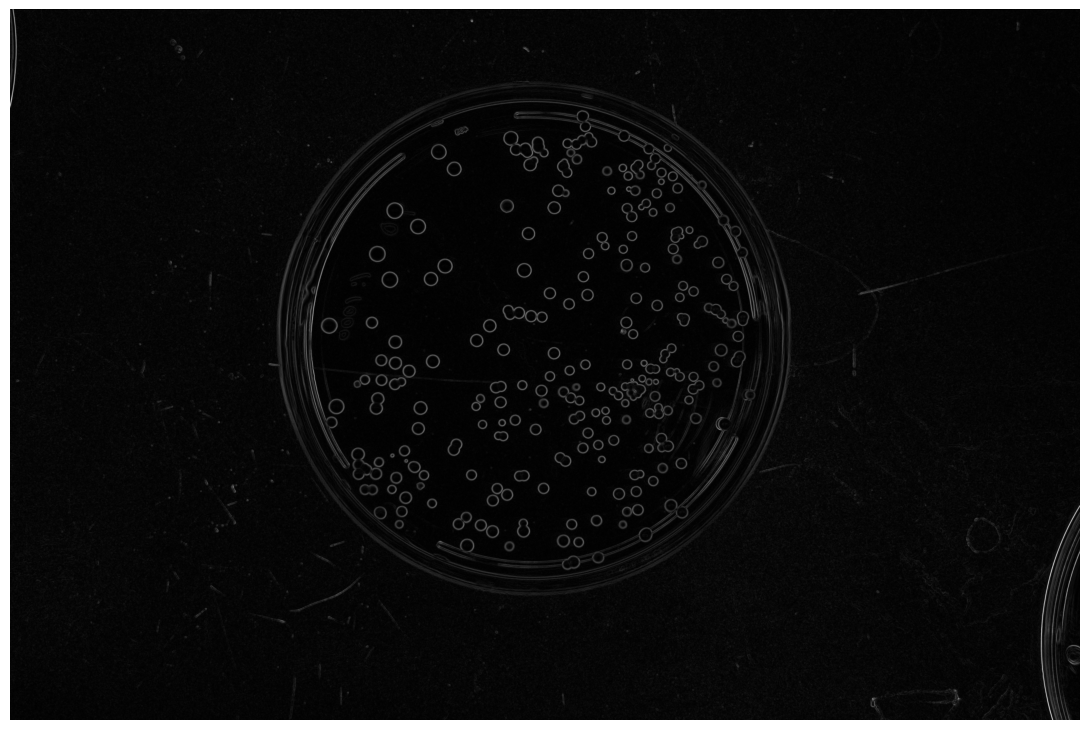

In [110]:
sobel_x = np.array([[2,  1,  0, -1, -2],
                    [3,  2,  0, -2, -3],
                    [4,  3,  0, -3, -4],
                    [3,  2,  0, -2, -3],
                    [2,  1,  0, -1, -2]])

sobel_y = np.array([[2,  3,  4,  3,  2],
                    [1,  2,  3,  2,  1],
                    [0,  0,  0,  0,  0],
                    [-1, -2, -3, -2, -1],
                    [-2, -3, -4, -3, -2]])

gradient_x = convolve(im_filtered, sobel_x)
gradient_y = convolve(im_filtered, sobel_y)

im_gradmag = np.sqrt(gradient_x**2 + gradient_y**2)

showim(im_gradmag, figsize=(11,11))

## 4  Watershed  segmentation  without  markers.  (1  pt.)  

*Apply  watershed  segmentation  to  the gradient  magnitude  image  (“im_gradmag”).  This  is  one  line  of  code  –  you don’t have to code the algorithm yourself!* 

*In Python:* **im_watershed = watershed(im_gradmag)** *Display this. To see something that isn't completely featureless, use a "prism" colormap, as shown:*
 
**plt.figure()** 

**plt.imshow(im_watershed, cmap='prism')**  

*Submit  the  segmented  image.  It  should  look  terrible.  (Notice  that  the  colored  bands  aren't  straight lines – it’s not just noise, but it’s not good!) The segmentation may take tens of seconds to run.*

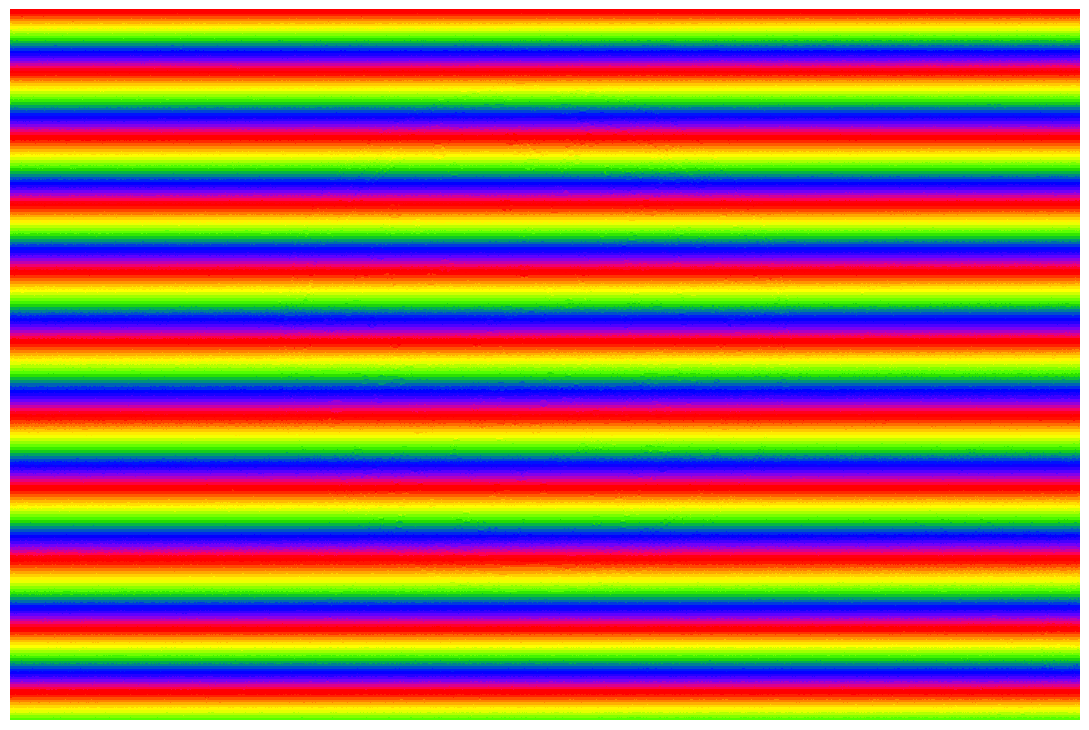

In [117]:
im_watershed = watershed(im_gradmag)
showim(im_watershed, figsize = (11,11), cmap='prism')

## 5 Watershed segmentation with markers (7 pts.)

#### a)  (3  pts.)  

*Make  a  binary  array that’s 1 at  the  local  maxima  of  the  filtered  (not  thresholded) image of yeast colonies from Exercise 2a, and 0 elsewhere. There are many ways to do this; I suggest  simply  assessing  whether  the  image  equals  its  dilated  image.  (If  you  want,  you  can look  into  **skimage.feature.peak_local_max**,  which  does  in  fact  use  the same  method.)* 

*You  should  find  many  maxima.  (If you show this “image,” don’t worry that it looks black. Zoom  in!)  Combine  these  with the thresholded image to only keep the “bright” maxima. How  can  you  combine  these?  Think  about  what  multiplying  by  your  thresholded  image (im_bw) does!* 

*Display the locations of the bright local maxima as “x”s on top of the original image, and submit this.* 

*Hint: use numpy.where to get the positions at which to put the x’s. (You can easily plot points on an image. In Python, for example,* **plt.plot(200,400,marker='x',color=darkorange)** *puts an “x” at (200, 400).)*

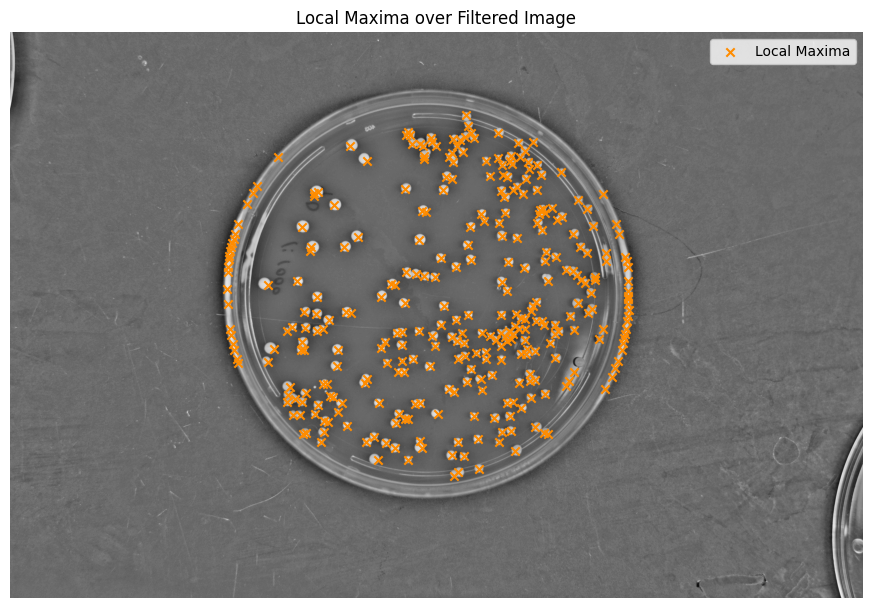

In [112]:
from skimage.feature import peak_local_max

bw_mask = im_bw.copy()
bw_mask = erosion(bw_mask, disk(5))

local_maxima = peak_local_max(im_filtered, min_distance=15)

maxima_mask = np.zeros_like(im_filtered, dtype=bool)
maxima_mask[local_maxima[:, 0], local_maxima[:, 1]] = True

combined_maxima = maxima_mask & (bw_mask > 0)
y_coords, x_coords = np.where(combined_maxima)

plt.figure(figsize=(11,11))
plt.imshow(im_filtered, cmap='gray')
plt.scatter(x_coords, y_coords, color='darkorange', marker='x', label='Local Maxima')
plt.legend(loc = 'upper right')
plt.title('Local Maxima over Filtered Image')
plt.axis(False);


(b)  (3  pts.)  

Apply  watershed  segmentation  to  the  gradient  magnitude  array  from  earlier,  but using the above-threshold local maxima from (a) as markers. See if colonies that touch each other can be recognized as separate objects! Optional: try different markers if you like, such as  dilating  the  maxima,  eroding  the  binary  thresholded  image,  etc.  Describe  what  you  find and  what  markers  you  used  and  submit  the  segmented  image.  (See  the  note  at  the  end  for how to impose markers.)

In brief, to segment the topography “im_gradmag”  

from skimage.segmentation import watershed 

labels = watershed(im_gradmag) 


Or, using a binary image of markers based on “markerBWimage”: 

markers = skmeasure.label(im_max) 

labels = watershed(im_gradmag, markers)

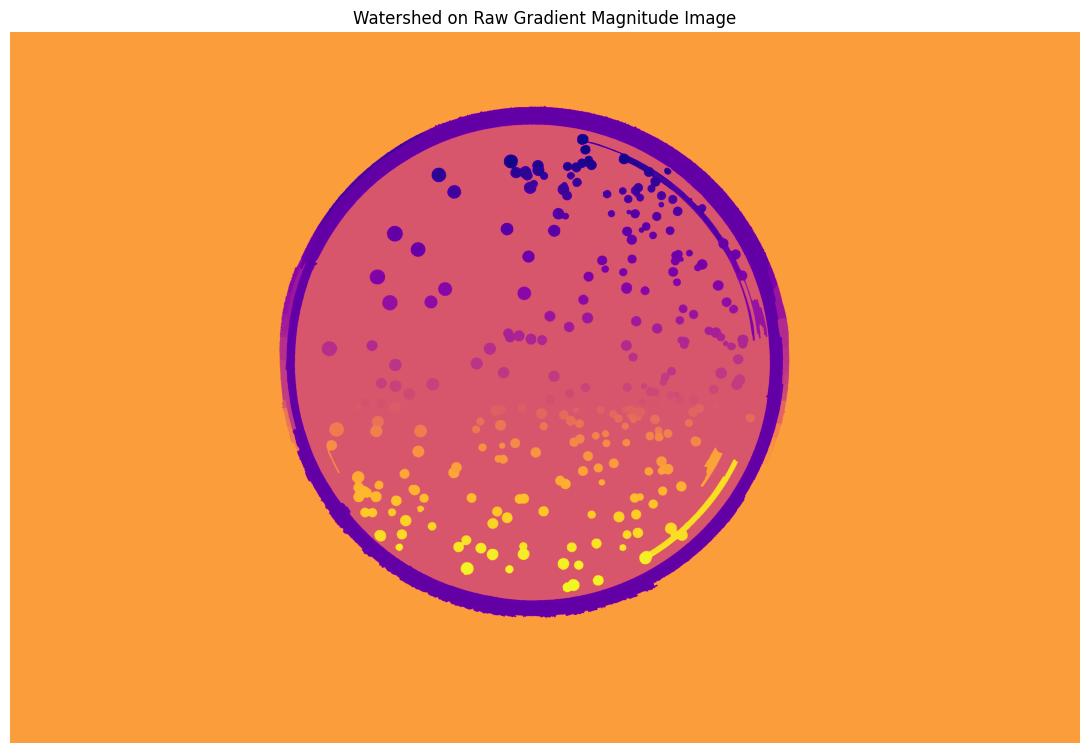

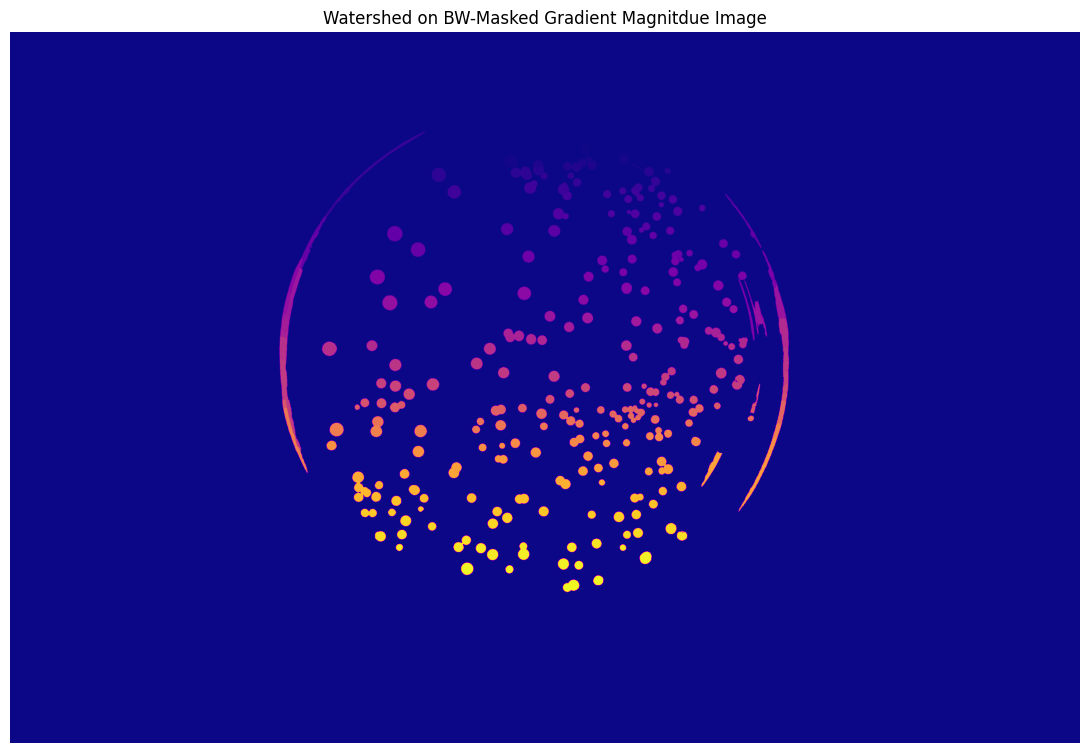

In [118]:
markers = skmeasure.label(combined_maxima)
labels = watershed(im_gradmag, markers = markers)
showim(labels, figsize = (11,11), cmap = 'plasma', titles = 'Watershed on Raw Gradient Magnitude Image')

labels2 = watershed(im_gradmag, markers = markers, mask = im_bw)
showim(labels2, figsize = (11,11), cmap = 'plasma', titles = 'Watershed on BW-Masked Gradient Magnitdue Image')


#### c) (1 pt.)

Run the same code as earlier to get statistics on the various regions you’ve found from segmentation  and  make  a  plot  of  eccentricity  vs.  Area.  You’ll find that there are still too many  objects,  but  hopefully  you  see  some  structure  in  your  plot.  Submit  your  plot,  and comment  on  whether  you  could  use  this  to  get  rid  of  objects  whose  properties imply  that they’re not colonies.

Text(0, 0.5, 'Area')

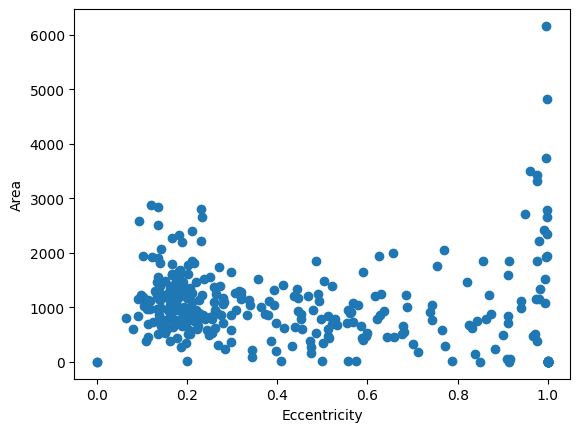

In [114]:
stats = skmeasure.regionprops(labels2) 
 
areas = [stats[j]['Area'] for j in range(len(stats))] 
eccentricities = [stats[j]['Eccentricity'] for j in range(len(stats))]

plt.scatter(eccentricities, areas);
plt.xlabel('Eccentricity')
plt.ylabel('Area')

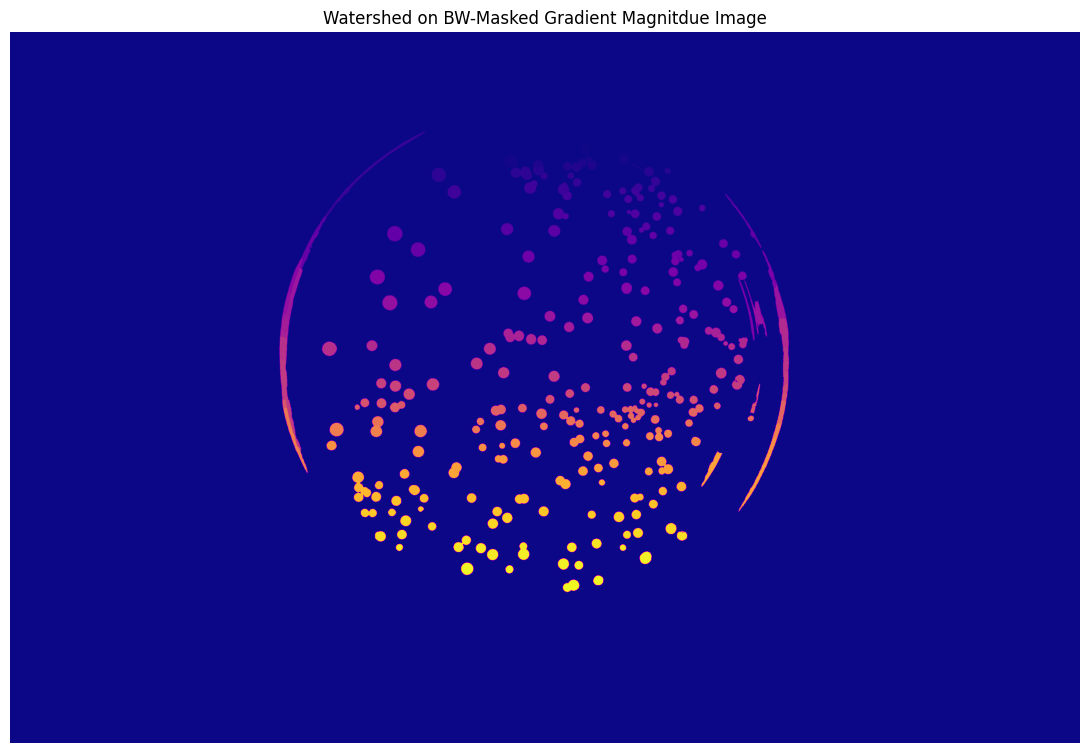

In [115]:
labels2 = watershed(im_gradmag, markers = markers, mask = im_bw)
showim(labels2, figsize = (11,11), cmap = 'plasma', titles = 'Watershed on BW-Masked Gradient Magnitdue Image')

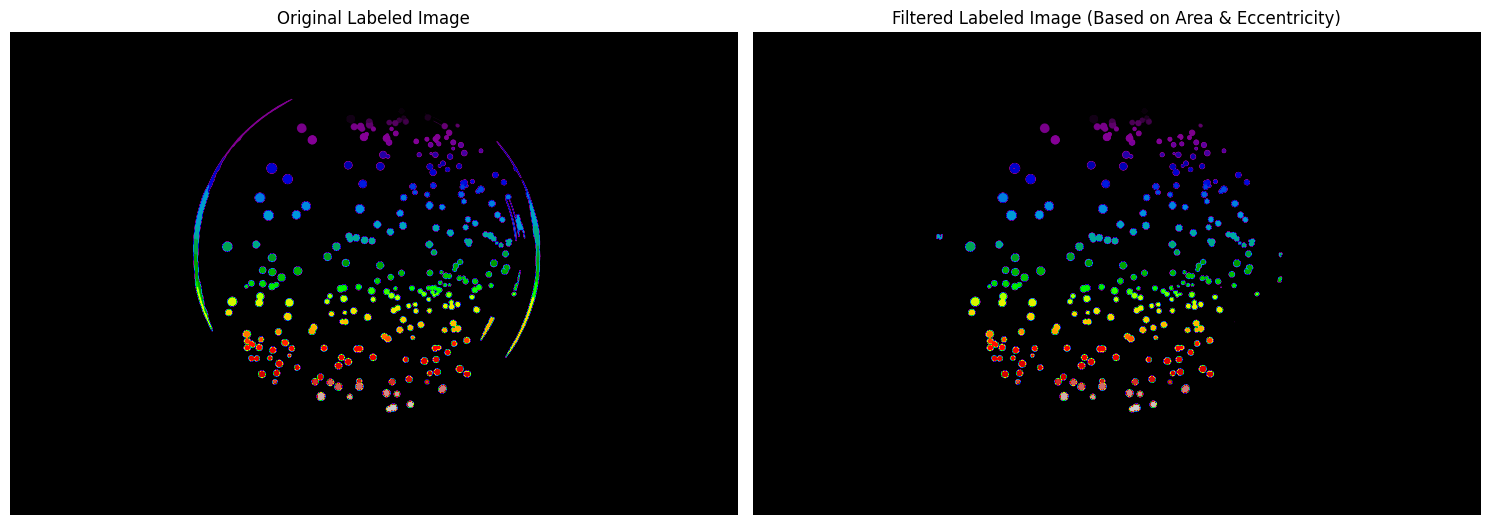

In [119]:
min_area = 0
max_area = 3000       
max_eccentricity = 0.8  

valid_labels = set(
    region.label
    for region in stats
    if min_area <= region.area <= max_area and region.eccentricity <= max_eccentricity
)

filtered_labels = np.where(np.isin(labels2, list(valid_labels)), labels2, 0)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].imshow(labels2, cmap='nipy_spectral')
ax[0].set_title('Original Labeled Image')
ax[0].set_axis_off()

ax[1].imshow(filtered_labels, cmap='nipy_spectral')
ax[1].set_title('Filtered Labeled Image (Based on Area & Eccentricity)')
ax[1].set_axis_off()

plt.tight_layout()
plt.show()